# M77 Coursework: 3D "Pac-Man"
The following coursework is designed to test multiple components of the module sylabus; including 3D geometry, object detection, feature extraction and image manipulation.

Your task is to complete the below skeleton code to play a Pac-Man-esque game in 3D. You are allowed to utilise method discussed in the course, including feature extractors and deep learning approaches.

The aim of the coursework is to step through a 3D pointcloud of the old PhD lab at Swansea University. Several large spheres have been placed within the space, it is your job to move through the pointcloud in an automated fashion, detecting the location of the sphere and moving to the predicted 3D location. If you land close enough to a sphere it will be captured and removed from the pointcloud. 

You will need to decide what kinds of feature you want to use, extract these features and train a classifier to detect the spheres within an image. You can then use the functionality provided in the PacMan_functionality.py module to obtain the XYZ coordinates of the pixel you predict to be a sphere.


## Imports
Hre we will do our usual imports. I would recommend numpy, scipy, skimage, matplotlib and sklearn. If you wish to utilise the pointcloud processing toolkit you can do that as described in the handout. We will want to import our PacMan_functionality module as well.

In [1]:
import PacMan_functionality as PacMan
import numpy as np
from numpy import asarray
import time

import cv2
import pptk

# For plotting:
%matplotlib inline
#%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# For operating-system tools and file-finding
import os
import glob
from os import listdir

# For resizing images
import skimage
import skimage.transform

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# For deep learning functionality
import tensorflow as tf
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPool2D
from tensorflow.python.keras.layers import SimpleRNN, LSTM

## Game setup.
This cell will initialise the game world and add all of our spheres to the world. Do not edit the code here.

In [2]:
# Call startup_scene() to load the initial game scene
global_cloud, spheres_collected = PacMan.startup_scene()

In [3]:
# View our pointcloud if we want
v = pptk.viewer(global_cloud['Positions'], global_cloud['Colors']/255) # Fast, requires pptk
PacMan.show_point_cloud(global_cloud) # Slow, requires matplotlib

### Supporting Functions

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['1', '0']

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [52]:
def sliding_window(no_of_steps):
    timestamp1 = time.time()

    stepSize = no_of_steps
    predict_array = list()
  
    window_patches = []
    center_x = list()
    center_y = list()

    (w_width, w_height) = (51, 51) # window size

    for x in range(0, image.shape[0] - w_width , stepSize):
      for y in range(0, image.shape[1] - w_height, stepSize):
         window = image[x:x + w_width, y:y + w_height, :]
         center_x.append(x + 25)
         center_y.append(y + 25)
         window_exp = np.expand_dims(window,0)
         window_patches.append(window)

    timestamp2 = time.time()
    print ("This sliding window took %.2f seconds" % (timestamp2 - timestamp1))

    return asarray(window_patches), asarray(center_x), asarray(center_y)

In [13]:
def highest_prob(patch_proba):
    pointer_position = 0
    highest_score = 0

    for i in range(len(patch_proba)):
        if highest_score < patch_proba[i,0]:
            highest_score = patch_proba[i,0]
            pointer_position = i
    
    return pointer_position, highest_score

## Load the training data: Positives and Negatives
In the handout zip file there is a directory which contains numerous patches extracted from sample images. These patches are labelled as either containing a sphere or not. You may wish to use these to train a classifier for sphere detection.

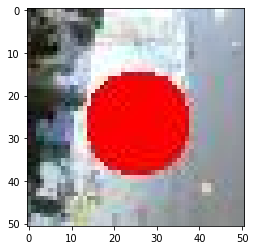

(51, 51, 3)


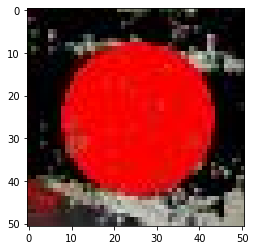

(51, 51, 3)


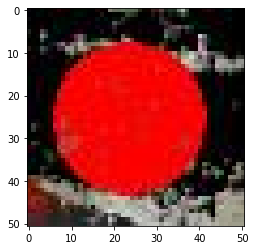

(51, 51, 3)


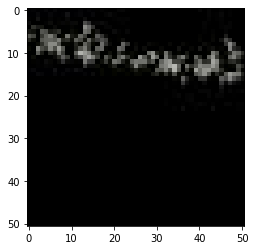

(51, 51, 3)


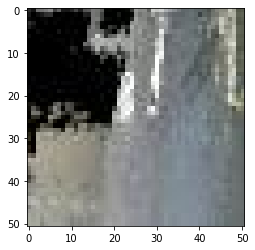

(51, 51, 3)


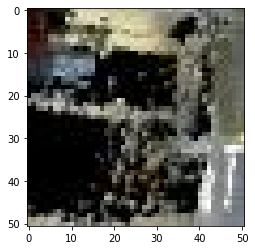

(51, 51, 3)


In [3]:
# Get the training samples for both positive and negative patches
pos_loaded_images = list()
neg_loaded_images = list()
all_images = list()
labels = list()

count = 0
for filename in listdir('TrainingImages/positives'):
    img_data = cv2.imread('TrainingImages/positives/' + filename)
    if count < 3:
        plt.imshow(cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB))
        plt.show()  # display!
        print(img_data.shape)
        count += 1

    all_images.append(img_data)
    labels.append(1)

count = 0
for filename in listdir('TrainingImages/negatives'):
    img_data = cv2.imread('TrainingImages/negatives/' + filename)
    if count < 3:
        plt.imshow(cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB))
        plt.show()  # display!
        print(img_data.shape)
        count += 1

    all_images.append(img_data)
    labels.append(0)
    
all_data = asarray(all_images)
labels = asarray(labels)

In [5]:
# https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/
# https://www.pyimagesearch.com/2014/11/03/display-matplotlib-rgb-image/

## Train a classifier on the samples, this may require feature extraction on the patches
Depending on your desired apporach you may want to extract features on the training patches you have been given. These can then be used to train our desired classifier to detect the patches based not on the raw data, but on a representative feature descriptor. Several are talked about both in the lectures and labs. 

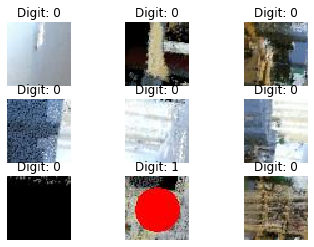

In [5]:
# Split Dataset
X = all_data
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.33) # Was removed from the end , random_state=42

# Get the one-hot encoded labels
n_class = len(np.unique(y_train))
Y_train = np.eye(n_class)[y_train]
Y_test = np.eye(n_class)[y_test]

plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB))#plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(y_train[i]))
    plt.axis('off')

## Testing out code ideas.

## CNN with Conv2D Mask shape 3 x 3

In [32]:
timestamp1 = time.time()
#CNN
X_train = X_train.astype('float32')

# Create the model using Sequential object
model = Sequential()

# Create the first hidden layer, this takes an argument of the input data shape (i.e. number of features)
model.add(Conv2D(10, (3, 3), input_shape=(X_train.shape[1:]))) 
model.add(Activation('relu'))                         
model.add(Dropout(0.2))

# Create the next hidden layer, this takes an argument of the input data shape (i.e. number of features)
model.add(MaxPool2D())
model.add(Activation('relu'))                         
model.add(Dropout(0.2))

# Create the dense head layer
model.add(Flatten())
model.add(Dense(50))
model.add(Activation('relu'))

# Create the output layer
model.add(Dense(2))
model.add(Activation('softmax'))

# Compile the model ready for training
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, validation_split=0.3)

timestamp2 = time.time()
print ("This took %.2f seconds" % (timestamp2 - timestamp1))

Train on 1363 samples, validate on 585 samples
Epoch 1/10
1363/1363 [==============================] - 1s 701us/sample - loss: 6.3971 - accuracy: 0.9516 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 2/10
1363/1363 [==============================] - 1s 444us/sample - loss: 5.4781e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 3/10
1363/1363 [==============================] - 1s 443us/sample - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 4/10
1363/1363 [==============================] - 1s 472us/sample - loss: 4.9595e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 5/10
1363/1363 [==============================] - 1s 437us/sample - loss: 0.0035 - accuracy: 0.9993 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 6/10
1363/1363 [==============================] - 1s 441us/sample - loss: 9.4790e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 7/10
1363/1363 [==============================]

In [62]:
X_test = X_test.astype('float32')

predicted_probability = model.predict(X_test)
predicted_classes = model.predict_classes(X_test)

correct_preds = np.nonzero(predicted_classes == y_test)[0]
incorrect_preds = np.nonzero(predicted_classes != y_test)[0]

print("{0} classified correctly".format(len(correct_preds)))
print("{0} classified incorrectly".format(len(incorrect_preds)))
print("{0:.2f}% of test set classified correctly".format(len(correct_preds) / len(y_test) * 100))

960 classified correctly
0 classified incorrectly
100.00% of test set classified correctly


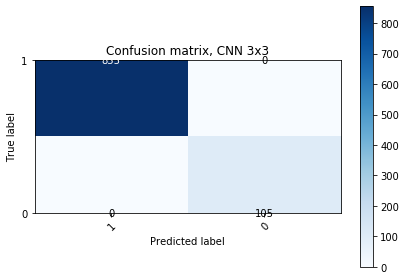

In [24]:
predicted_labels = np.argmax(predicted_probability, axis=1)
y_train_labels = np.argmax(Y_test, axis=1)

plot_confusion_matrix(y_train_labels, predicted_classes,classes=Y_train,
                      title='Confusion matrix, CNN 3x3' )

plt.show()

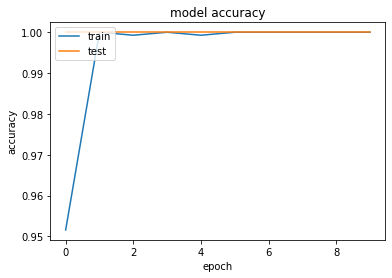

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [34]:
# Summarize history for accuracy
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.figure()

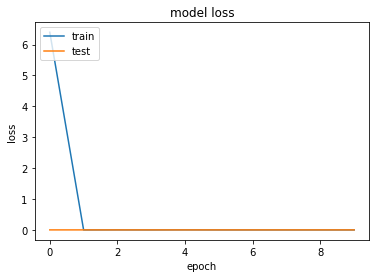

In [35]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Initialise our starting point in the game and get our first view into the scene
We should start the game at a position of XYZ = [0, 0, 0] and a camera angle of [0, 0, 0]. These variables can be updated once we find a sphere, or rotated when we don't find a sphere. We can then get our first image projected to the camera plane to start our game. 

## Perform our loop, in which we will perform pixel-wise prediction on binary class label and then perform the correct action based on detection of spheres.
This will be the main bulk of your implementation, utilising the feature descriptors and trained models from the above cells. In each loop of the program we will want to:
-  Get current view into the scene
-  Extract patches from the scene
-  Extract features on the patches
-  Use the pretrained model to obtain class prediction probabilities
-  Identify if a sphere has been found in the scene
  -  If so, find the mapped XYZ location, move there and update the scene
  -  If not, rotate the camera in a bid to find the sphere


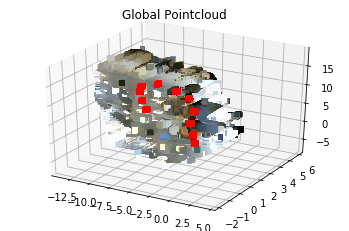

This sliding window took 0.01 seconds
I am now at position [-0.22769290645257315, 0.07758786441158835, 2.3143270537449827]
I have found 1 out of 11 spheres!



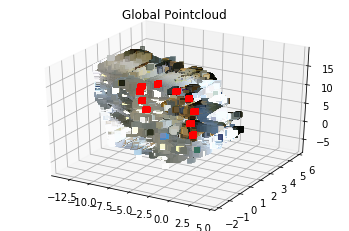

This sliding window took 0.01 seconds
I am now at position [-0.3339026254635002, -0.03368276456942336, 4.67416503318728]
I have found 2 out of 11 spheres!



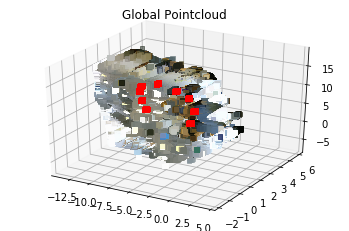

This sliding window took 0.01 seconds
I am now at position [-0.9373297537132663, 0.19822975371326632, 7.008997371364827]
I have found 3 out of 11 spheres!



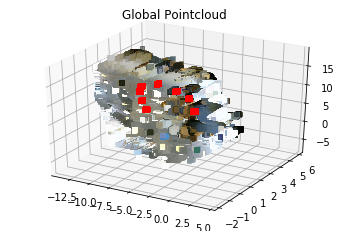

This sliding window took 0.01 seconds
I am now at position [-1.0605394452238583, 0.6115700554218513, 9.38150077613352]
I have found 4 out of 11 spheres!



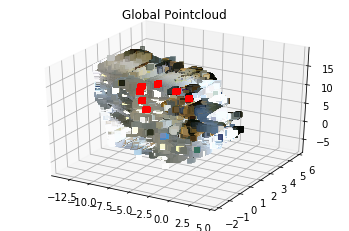

This sliding window took 0.01 seconds
I am now at position [-1.912366710871844, 0.773366710871844, 12.174308141285747]
I have found 5 out of 11 spheres!



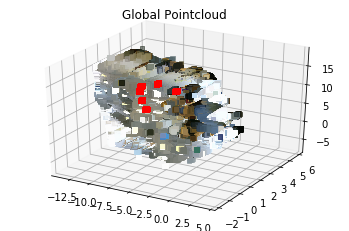

This sliding window took 0.01 seconds
I am now at position [-2.191962718963623, 0.8816171288490295, 14.175887107849121]
I can not find any red balls!
I am scanning the room....


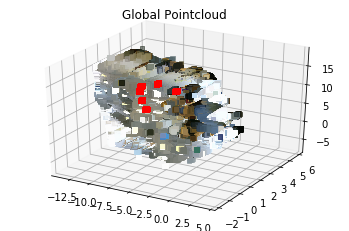

This sliding window took 0.01 seconds
I am now at position [-3.7947614192962646, 0.9762549996376038, 15.932765007019043]
I can not find any red balls!
I am scanning the room....


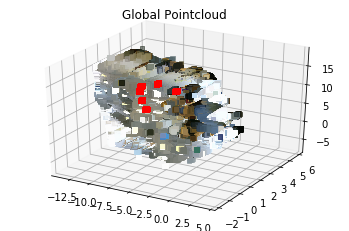

This sliding window took 0.01 seconds
I am now at position [-3.7692462913497633, 1.0877, 12.907002158413938]
I have found 6 out of 11 spheres!



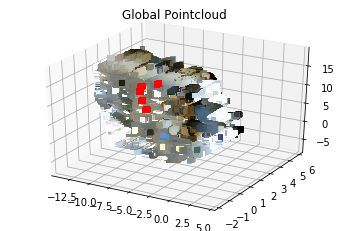

This sliding window took 0.01 seconds
I am now at position [-6.557034268826188, 1.4556838951575082, 13.220974085159522]
I have found 7 out of 11 spheres!



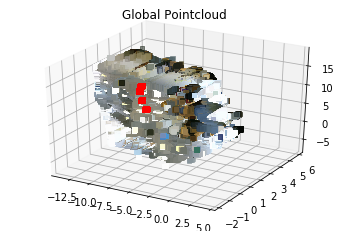

This sliding window took 0.01 seconds
I am now at position [0.0, 0.0, 0.0]
I can not find any red balls!
I am scanning the room....


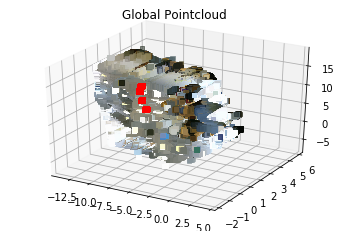

This sliding window took 0.01 seconds
I am now at position [-8.888768394070881, 1.6651658080191407, 11.51638212998399]
I have found 8 out of 11 spheres!



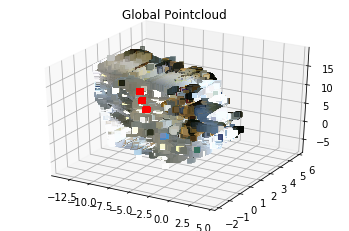

This sliding window took 0.01 seconds
I am now at position [-12.933381080627441, 1.227052092552185, 9.877522468566895]
I can not find any red balls!
I am scanning the room....


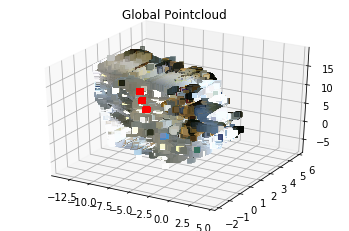

This sliding window took 0.01 seconds
I am now at position [-9.357172456596137, 1.8192, 9.769072736187109]
I have found 9 out of 11 spheres!



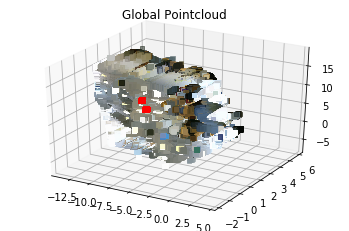

This sliding window took 0.01 seconds
I am now at position [-9.237134712326862, 1.8655775394272787, 7.259138225647763]
I have found 10 out of 11 spheres!



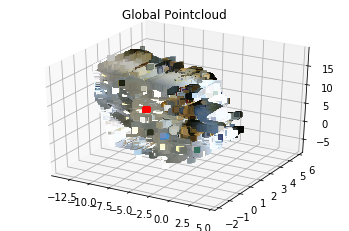

This sliding window took 0.01 seconds
I am now at position [-9.038472992588384, 2.0728658760068686, 4.556540106161687]
I have found 11 out of 11 spheres!

This took 637.75 seconds


In [38]:
global_cloud, spheres_collected = PacMan.startup_scene()

position = np.zeros([3])
angle = np.zeros([3])
previous_position = np.zeros([3])
failed = False
lost = 0

timestamp1 = time.time()

# Get current image from viewpoint
image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, position)

while not np.all(spheres_collected): # While there are spheres to find
    PacMan.show_point_cloud(global_cloud)
    
    # Extracting Window Patches, X and Y center points
    patches, x_center, y_center = sliding_window(2)
    
    # Predicting probabilities on window patches
    patch_probabilities = model.predict_proba(patches)

    # Get highest probability window location
    image_position, highest_percent = highest_prob(patch_probabilities)
    
    # Use probabilities to find sphere coordinates in 3D
    position[0] = map1[x_center[image_position],y_center[image_position]]
    position[1] = map2[x_center[image_position],y_center[image_position]]
    position[2] = map3[x_center[image_position],y_center[image_position]]
        
    print('I am now at position [{0}, {1}, {2}]'.format(*position))
    
    try:
        global_cloud, spheres_collected = PacMan.update_scene(position, spheres_collected);
        print('I have found {0} out of {1} spheres!\n'.format(np.sum(spheres_collected), len(spheres_collected)));
        for i in range(3):
            previous_position[i] = position[i]
        failed = False
        image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, position)
    except:
        print("I can not find any red balls!")
        print("I am scanning the room....")
        if failed != True:
            for i in range(3):
                position[i] = previous_position[i]
        failed = True
        global_cloud, spheres_collected = PacMan.update_scene(previous_position, spheres_collected);
        
    if failed == True:
        angle[1] -= 0.75
        image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, previous_position)

timestamp2 = time.time()
print ("This took %.2f seconds" % (timestamp2 - timestamp1))

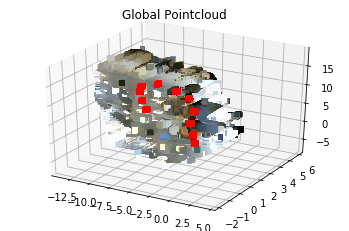

This sliding window took 0.00 seconds
I am now at position [-0.22103972623411064, 0.06579168014111224, 2.311564804229028]
Angle = [0. 0. 0.]
I have found 1 out of 11 spheres!



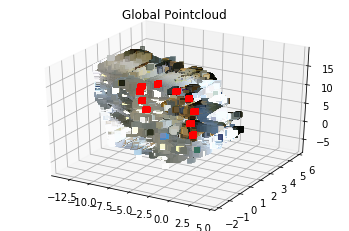

This sliding window took 0.00 seconds
I am now at position [-0.3274352591955457, -0.04055592640224332, 4.6735081412857475]
Angle = [0. 0. 0.]
I have found 2 out of 11 spheres!



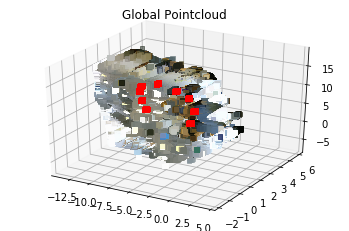

This sliding window took 0.00 seconds
I am now at position [-0.9385528911820715, 0.19945289118207146, 7.00876503318728]
Angle = [0. 0. 0.]
I have found 3 out of 11 spheres!



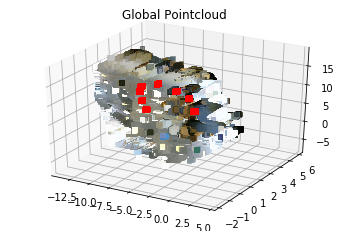

This sliding window took 0.00 seconds
I am now at position [-1.0458784953734843, 0.6058817207619711, 9.382027053744983]
Angle = [0. 0. 0.]
I have found 4 out of 11 spheres!



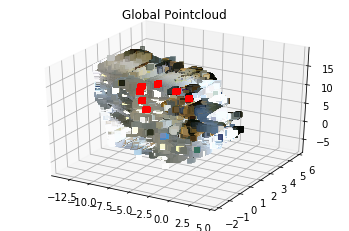

This sliding window took 0.00 seconds
I am now at position [-1.9166999529391782, 0.7592061929281059, 12.175743408205024]
Angle = [0. 0. 0.]
I have found 5 out of 11 spheres!



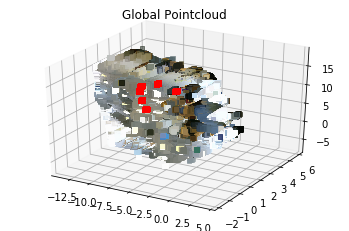

This sliding window took 0.00 seconds
I am now at position [-1.849158763885498, 0.7567659616470337, 16.315174102783203]
Angle = [0. 0. 0.]
I can not find any red balls!
I am scanning the room....


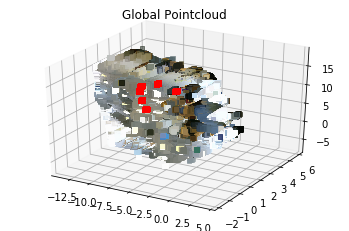

This sliding window took 0.00 seconds
I am now at position [-3.756636619567871, 0.8946484923362732, 15.945444107055664]
Angle = [ 0.   -0.75  0.  ]
I can not find any red balls!
I am scanning the room....


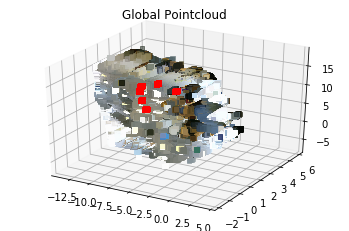

This sliding window took 0.00 seconds
I am now at position [-3.792165549227548, 1.0720472036267514, 12.896246718609857]
Angle = [ 0.  -1.5  0. ]
I have found 6 out of 11 spheres!



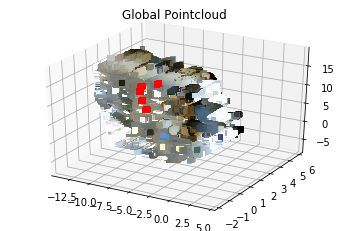

This sliding window took 0.00 seconds
I am now at position [-6.562108311867646, 1.4563248958611443, 13.19890917575576]
Angle = [ 0.  -1.5  0. ]
I have found 7 out of 11 spheres!



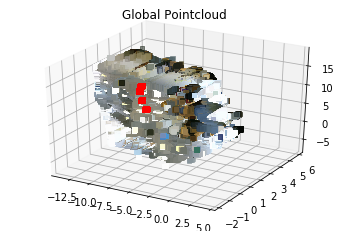

This sliding window took 0.00 seconds
I am now at position [0.0, 0.0, 0.0]
Angle = [ 0.  -1.5  0. ]
I can not find any red balls!
I am scanning the room....


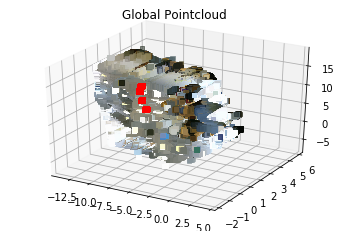

This sliding window took 0.00 seconds
I am now at position [-8.890739617006691, 1.6590589230203865, 11.519492201584507]
Angle = [ 0.   -2.25  0.  ]
I have found 8 out of 11 spheres!



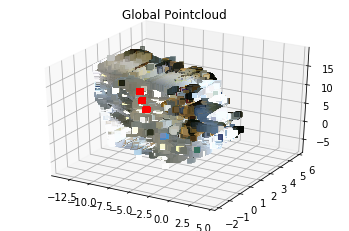

This sliding window took 0.00 seconds
I am now at position [-12.933381080627441, 1.227052092552185, 9.877522468566895]
Angle = [ 0.   -2.25  0.  ]
I can not find any red balls!
I am scanning the room....


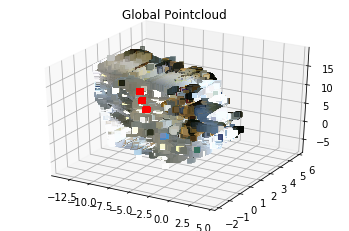

This sliding window took 0.00 seconds
I am now at position [-9.36046794625407, 1.831062808228714, 9.769753281390143]
Angle = [ 0. -3.  0.]
I have found 9 out of 11 spheres!



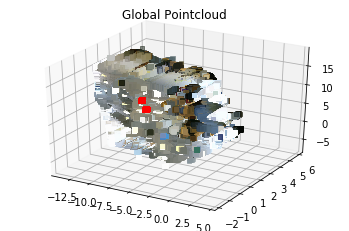

This sliding window took 0.00 seconds
I am now at position [-9.232168296195741, 1.8663472313193727, 7.257172736187109]
Angle = [ 0. -3.  0.]
I have found 10 out of 11 spheres!



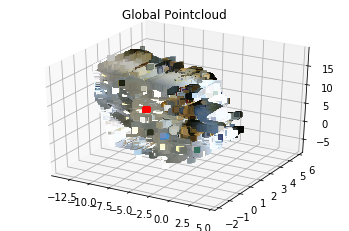

This sliding window took 0.00 seconds
I am now at position [-9.007198840884508, 2.055502884329272, 4.551220595425283]
Angle = [ 0. -3.  0.]
I have found 11 out of 11 spheres!

This took 641.66 seconds


In [39]:
# Siding window 5 steps
global_cloud, spheres_collected = PacMan.startup_scene()

position = np.zeros([3])
angle = np.zeros([3])
previous_position = np.zeros([3])
failed = False
lost = 0

timestamp1 = time.time()

# Get current image from viewpoint
image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, position)

while not np.all(spheres_collected): # While there are spheres to find
    PacMan.show_point_cloud(global_cloud)
    # Extract patches from the scene
    
    # Extracting Window Patches, X and Y center points
    patches, x_center, y_center = sliding_window(5)

    # Extract features from the patches
    
    # Predict the probability of a pixel being a sphere, based on the patch
    # Predicting probabilities on window patches
    patch_probabilities = model.predict_proba(patches)

    # Use probabilities to find sphere coordinates in 3D
    # Get highest probability window location
    image_position, highest_percent = highest_prob(patch_probabilities)

    position[0] = map1[x_center[image_position],y_center[image_position]]
    position[1] = map2[x_center[image_position],y_center[image_position]]
    position[2] = map3[x_center[image_position],y_center[image_position]]
        
    print('I am now at position [{0}, {1}, {2}]'.format(*position))
    print("Angle =", angle)
    
    try:
        global_cloud, spheres_collected = PacMan.update_scene(position, spheres_collected);
        print('I have found {0} out of {1} spheres!\n'.format(np.sum(spheres_collected), len(spheres_collected)));
        for i in range(3):
            previous_position[i] = position[i]
        failed = False
        image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, position)
    except:
        print("I can not find any red balls!")
        print("I am scanning the room....")
        if failed != True:
            for i in range(3):
                position[i] = previous_position[i]
        failed = True
        global_cloud, spheres_collected = PacMan.update_scene(previous_position, spheres_collected);
        
    if failed == True:
        angle[1] -= 0.75
        image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, previous_position)

timestamp2 = time.time()
print ("This took %.2f seconds" % (timestamp2 - timestamp1))

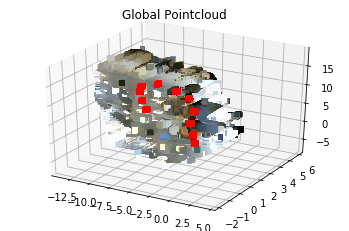

This sliding window took 0.00 seconds
I am now at position [-0.26208158696191186, 0.10616144089683133, 2.3414325798681612]
I have found 1 out of 11 spheres!



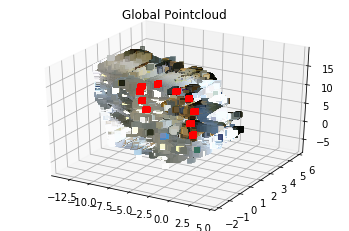

This sliding window took 0.00 seconds
I am now at position [-0.3677010768304985, -0.019830550040031755, 4.685399275090181]
I have found 2 out of 11 spheres!



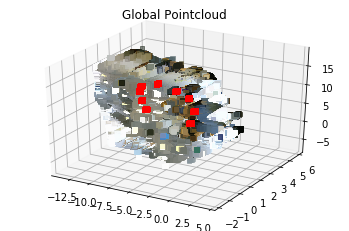

This sliding window took 0.00 seconds
I am now at position [-0.9380986295740176, 0.18549493749741808, 7.010958897733591]
I have found 3 out of 11 spheres!



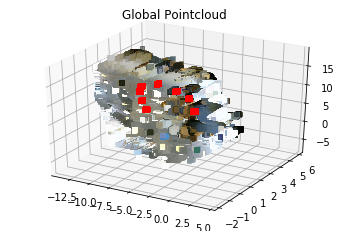

This sliding window took 0.00 seconds
I am now at position [-1.0238525867462158, 0.4277941882610321, 8.58199405670166]
I can not find any red balls!
I am scanning the room....


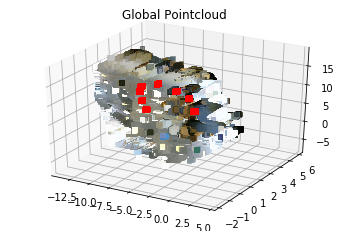

This sliding window took 0.00 seconds
I am now at position [-1.5401082038879395, 0.37498047947883606, 8.18394947052002]
I can not find any red balls!
I am scanning the room....


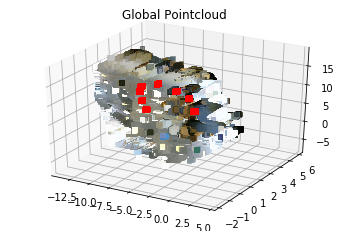

This sliding window took 0.00 seconds
I am now at position [-12.955564498901367, 1.9790449142456055, 10.496173858642578]
I can not find any red balls!
I am scanning the room....


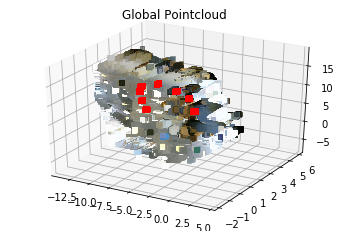

This sliding window took 0.00 seconds
I am now at position [-6.798246383666992, 0.6115894317626953, 1.8089650869369507]
I can not find any red balls!
I am scanning the room....


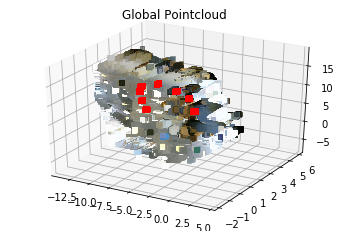

This sliding window took 0.00 seconds
I am now at position [-1.108532428741455, 0.02730337344110012, 4.01620626449585]
I can not find any red balls!
I am scanning the room....


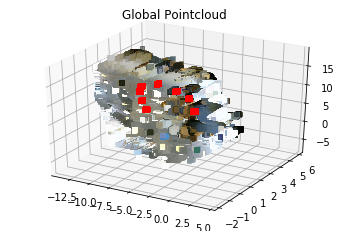

This sliding window took 0.00 seconds
I am now at position [1.724198818206787, 0.33348366618156433, 4.9548726081848145]
I can not find any red balls!
I am scanning the room....


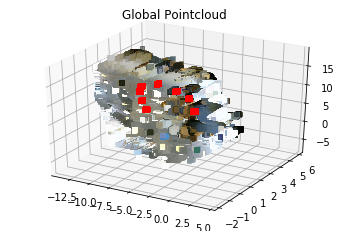

This sliding window took 0.00 seconds
I am now at position [2.7802822589874268, -0.12214135378599167, 7.347336769104004]
I can not find any red balls!
I am scanning the room....


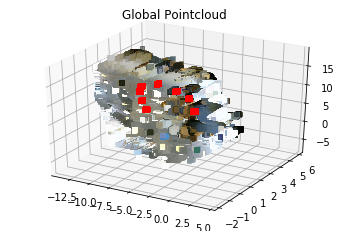

This sliding window took 0.00 seconds
I am now at position [0.0, 0.0, 0.0]
I can not find any red balls!
I am scanning the room....


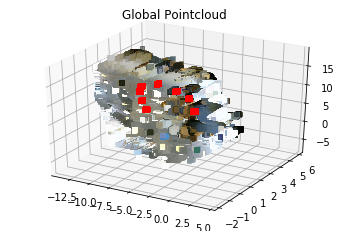

This sliding window took 0.00 seconds
I am now at position [-1.003521152927669, 0.5448102126263801, 9.448425017357861]
I have found 4 out of 11 spheres!



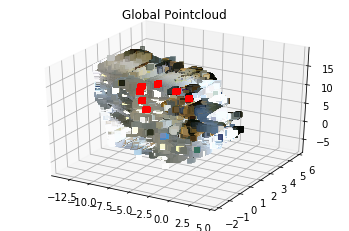

This sliding window took 0.00 seconds
I am now at position [1.6317501068115234, 0.08767055720090866, 14.262447357177734]
I can not find any red balls!
I am scanning the room....


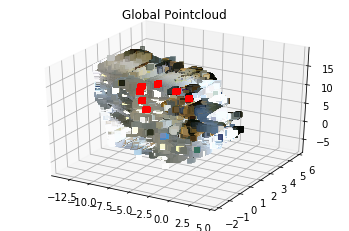

This sliding window took 0.00 seconds
I am now at position [-1.8872748791761944, 0.7705908592576785, 12.178500701591451]
I have found 5 out of 11 spheres!



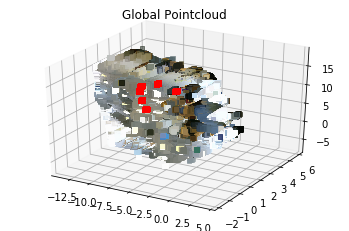

This sliding window took 0.00 seconds
I am now at position [-2.27711820602417, 0.9999915957450867, 14.224994659423828]
I can not find any red balls!
I am scanning the room....


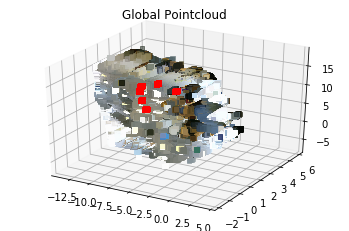

This sliding window took 0.00 seconds
I am now at position [-3.759270156909509, 1.0691031771060797, 12.9167187672246]
I have found 6 out of 11 spheres!



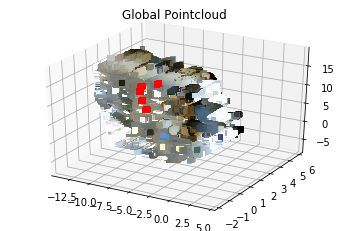

This sliding window took 0.00 seconds
I am now at position [-6.556014389363907, 1.4660309924327923, 13.222707298767661]
I have found 7 out of 11 spheres!



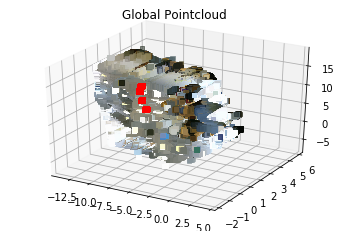

This sliding window took 0.00 seconds
I am now at position [-11.417126655578613, 0.6701055765151978, 15.126457214355469]
I can not find any red balls!
I am scanning the room....


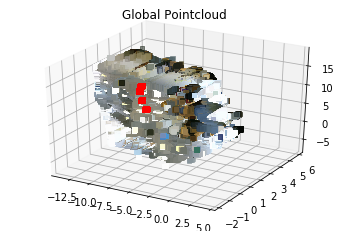

This sliding window took 0.00 seconds
I am now at position [-8.892609564912823, 1.6194413829599892, 11.495132209684984]
I have found 8 out of 11 spheres!



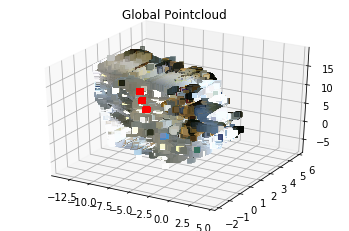

This sliding window took 0.00 seconds
I am now at position [-13.017048835754395, 1.1279518604278564, 10.178805351257324]
I can not find any red balls!
I am scanning the room....


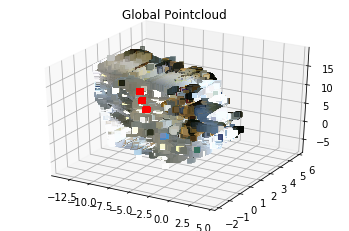

This sliding window took 0.00 seconds
I am now at position [-9.333232819886604, 1.8170609026889355, 9.754895001375075]
I have found 9 out of 11 spheres!



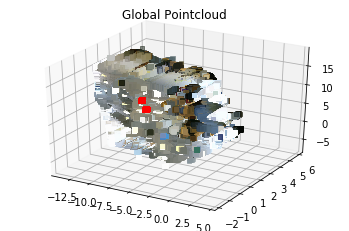

This sliding window took 0.00 seconds
I am now at position [-12.400527954101562, 2.5563619136810303, 4.186269283294678]
I can not find any red balls!
I am scanning the room....


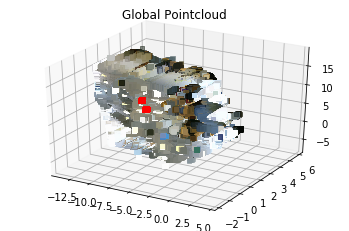

This sliding window took 0.00 seconds
I am now at position [-9.219678669455917, 1.9269213305440824, 7.232523644065813]
I have found 10 out of 11 spheres!



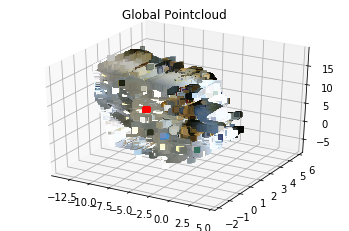

This sliding window took 0.00 seconds
I am now at position [-9.016670453187647, 2.0698668051100895, 4.555556591794975]
I have found 11 out of 11 spheres!

This took 856.81 seconds


In [41]:
# Sliding window 10 steps

global_cloud, spheres_collected = PacMan.startup_scene()

position = np.zeros([3])
angle = np.zeros([3])
previous_position = np.zeros([3])
failed = False
lost = 0

timestamp1 = time.time()

# Get current image from viewpoint
image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, position)

while not np.all(spheres_collected): # While there are spheres to find
    PacMan.show_point_cloud(global_cloud)
    # Extract patches from the scene
    
    # Extracting Window Patches, X and Y center points
    patches, x_center, y_center = sliding_window(10)

    # Extract features from the patches
    
    # Predict the probability of a pixel being a sphere, based on the patch
    # Predicting probabilities on window patches
    patch_probabilities = model.predict_proba(patches)

    # Use probabilities to find sphere coordinates in 3D
    # Get highest probability window location
    image_position, highest_percent = highest_prob(patch_probabilities)

    position[0] = map1[x_center[image_position],y_center[image_position]]
    position[1] = map2[x_center[image_position],y_center[image_position]]
    position[2] = map3[x_center[image_position],y_center[image_position]]
        
    print('I am now at position [{0}, {1}, {2}]'.format(*position))
    
    try:
        global_cloud, spheres_collected = PacMan.update_scene(position, spheres_collected);
        print('I have found {0} out of {1} spheres!\n'.format(np.sum(spheres_collected), len(spheres_collected)));
        for i in range(3):
            previous_position[i] = position[i]
        failed = False
        image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, position)
    except:
        print("I can not find any red balls!")
        print("I am scanning the room....")
        if failed != True:
            for i in range(3):
                position[i] = previous_position[i]
        failed = True
        global_cloud, spheres_collected = PacMan.update_scene(previous_position, spheres_collected);
        
    if failed == True:
        angle[1] -= 0.75
        image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, previous_position)


timestamp2 = time.time()
print ("This took %.2f seconds" % (timestamp2 - timestamp1))

## CNN with a Mask size of 6x6

In [55]:
timestamp1 = time.time()
#CNN
X_train = X_train.astype('float32')

# Create the model using Sequential object
model = Sequential()

# Create the first hidden layer, this takes an argument of the input data shape (i.e. number of features)
model.add(Conv2D(10, (6, 6), input_shape=(X_train.shape[1:]))) 
model.add(Activation('relu'))                         
model.add(Dropout(0.2))

# Create the next hidden layer, this takes an argument of the input data shape (i.e. number of features)
model.add(MaxPool2D())
model.add(Activation('relu'))                         
model.add(Dropout(0.2))

# Create the dense head layer
model.add(Flatten())
model.add(Dense(50))
model.add(Activation('relu'))

# Create the output layer
model.add(Dense(2))
model.add(Activation('softmax'))

# Compile the model ready for training
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, validation_split=0.3)

timestamp2 = time.time()
print ("This took %.2f seconds" % (timestamp2 - timestamp1))

Train on 1363 samples, validate on 585 samples
Epoch 1/10
1363/1363 [==============================] - 1s 878us/sample - loss: 5.6918 - accuracy: 0.9164 - val_loss: 0.1501 - val_accuracy: 0.9829
Epoch 2/10
1363/1363 [==============================] - 1s 638us/sample - loss: 0.0472 - accuracy: 0.9934 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 3/10
1363/1363 [==============================] - 1s 628us/sample - loss: 0.0011 - accuracy: 0.9993 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 4/10
1363/1363 [==============================] - 1s 623us/sample - loss: 4.4468e-04 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 5/10
1363/1363 [==============================] - 1s 630us/sample - loss: 4.4730e-04 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 6/10
1363/1363 [==============================] - 1s 627us/sample - loss: 4.2682e-04 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 7/10
1363/1363 [==============================]

In [56]:
X_test = X_test.astype('float32')

predicted_probability = model.predict(X_test)
predicted_class = predicted_classes = model.predict_classes(X_test)

correct_preds = np.nonzero(predicted_classes == y_test)[0]
incorrect_preds = np.nonzero(predicted_classes != y_test)[0]

print("{0} classified correctly".format(len(correct_preds)))
print("{0} classified incorrectly".format(len(incorrect_preds)))
print("{0:.2f}% of test set classified correctly".format(len(correct_preds) / len(y_test) * 100))

960 classified correctly
0 classified incorrectly
100.00% of test set classified correctly


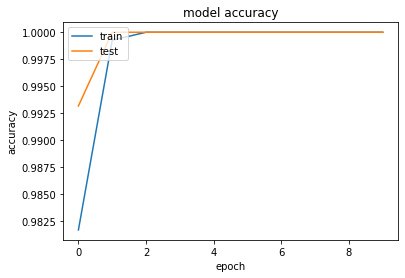

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [51]:
# Summarize history for accuracy
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.figure()

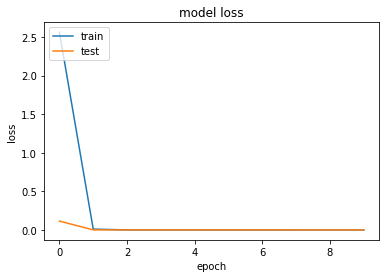

In [52]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

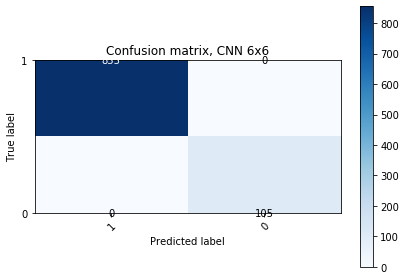

In [28]:
predicted_labels = np.argmax(predicted_probability, axis=1)
y_train_labels = np.argmax(Y_test, axis=1)

plot_confusion_matrix(y_train_labels, predicted_classes,classes=Y_train,
                      title='Confusion matrix, CNN 6x6' )

plt.show()

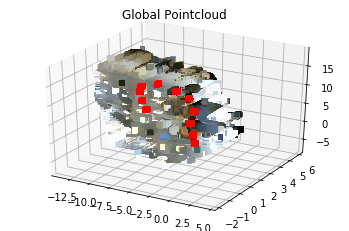

This sliding window took 0.01 seconds
I am now at position [-0.2443154570436885, 0.059029455230867334, 2.319463660837109]
I have found 1 out of 11 spheres!



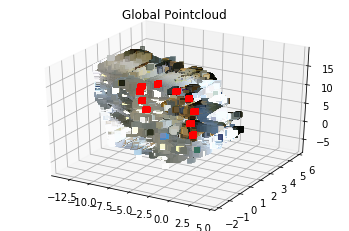

This sliding window took 0.01 seconds
I am now at position [-0.33461610484249193, -0.03665462006270172, 4.67416503318728]
I have found 2 out of 11 spheres!



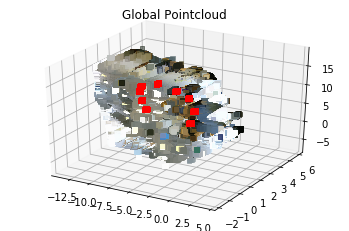

This sliding window took 0.01 seconds
I am now at position [-0.9379540171234262, 0.20009062728050503, 7.00876503318728]
I have found 3 out of 11 spheres!



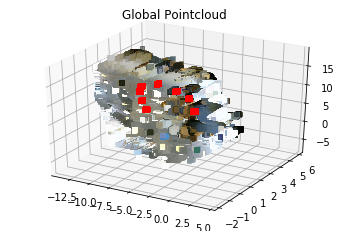

This sliding window took 0.01 seconds
I am now at position [-1.0605797808444413, 0.6135178477635246, 9.381000701591452]
I have found 4 out of 11 spheres!



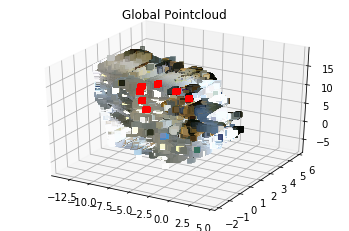

This sliding window took 0.01 seconds
I am now at position [-1.8947639492882278, 0.7693773463155236, 12.176764804229029]
I have found 5 out of 11 spheres!



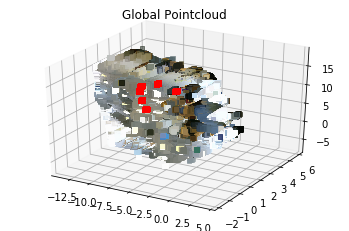

This sliding window took 0.01 seconds
I am now at position [-1.8065391778945923, 1.1123921871185303, 14.200555801391602]
I can not find any red balls!
I am scanning the room....


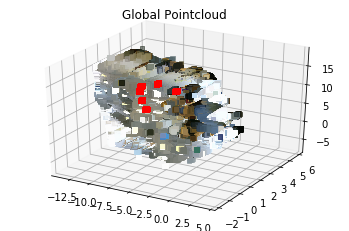

This sliding window took 0.01 seconds
I am now at position [-3.7249739170074463, 0.9408077597618103, 15.94679069519043]
I can not find any red balls!
I am scanning the room....


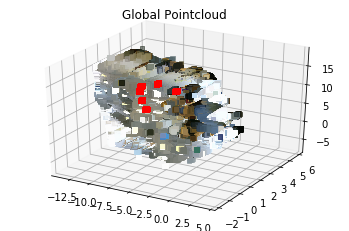

This sliding window took 0.01 seconds
I am now at position [-3.7617470841455094, 1.076620546573317, 12.913287417469357]
I have found 6 out of 11 spheres!



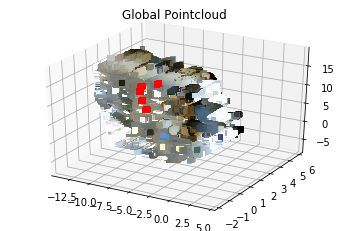

This sliding window took 0.01 seconds
I am now at position [-6.559210834095276, 1.4559588592950994, 13.208961626238233]
I have found 7 out of 11 spheres!



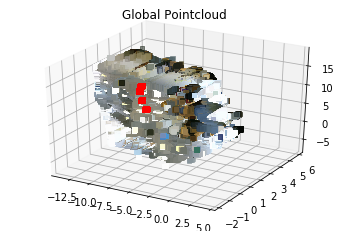

This sliding window took 0.01 seconds
I am now at position [-11.252372741699219, 0.6558665037155151, 15.022074699401855]
I can not find any red balls!
I am scanning the room....


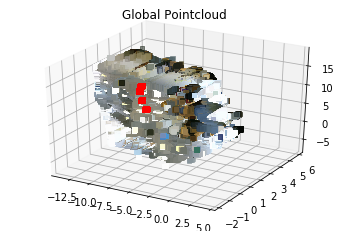

This sliding window took 0.01 seconds
I am now at position [-8.894182653652905, 1.659384385807224, 11.525555396079548]
I have found 8 out of 11 spheres!



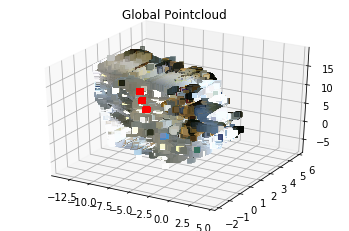

This sliding window took 0.01 seconds
I am now at position [-12.175360679626465, 1.653005599975586, 9.552194595336914]
I can not find any red balls!
I am scanning the room....


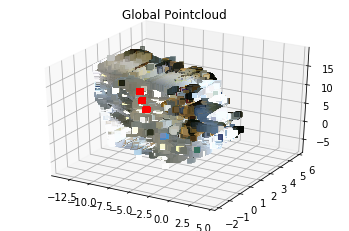

This sliding window took 0.01 seconds
I am now at position [-9.333059123341078, 1.8061823565689716, 9.753814489704258]
I have found 9 out of 11 spheres!



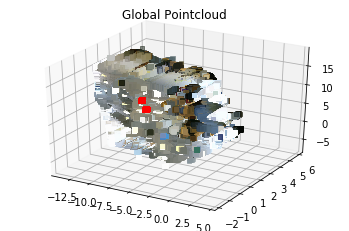

This sliding window took 0.01 seconds
I am now at position [-9.246074879176193, 1.8627908592576785, 7.261899298408549]
I have found 10 out of 11 spheres!



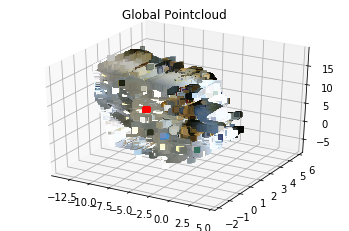

This sliding window took 0.01 seconds
I am now at position [-9.012449114021459, 2.0730478514832638, 4.555243027858744]
I have found 11 out of 11 spheres!

This took 757.05 seconds


In [57]:
# 2 step sliding window
global_cloud, spheres_collected = PacMan.startup_scene()

position = np.zeros([3])
angle = np.zeros([3])
previous_position = np.zeros([3])
failed = False

timestamp1 = time.time()

# Get current image from viewpoint
image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, position)

while not np.all(spheres_collected): # While there are spheres to find
    PacMan.show_point_cloud(global_cloud)
    # Extract patches from the scene
    
    # Extracting Window Patches, X and Y center points
    patches, x_center, y_center = sliding_window(2)

    # Extract features from the patches
    
    # Predict the probability of a pixel being a sphere, based on the patch
    # Predicting probabilities on window patches
    patch_probabilities = model.predict_proba(patches)

    # Use probabilities to find sphere coordinates in 3D
    # Get highest probability window location
    image_position, highest_percent = highest_prob(patch_probabilities)

    position[0] = map1[x_center[image_position],y_center[image_position]]
    position[1] = map2[x_center[image_position],y_center[image_position]]
    position[2] = map3[x_center[image_position],y_center[image_position]]
        
    print('I am now at position [{0}, {1}, {2}]'.format(*position))
    
    try:
        global_cloud, spheres_collected = PacMan.update_scene(position, spheres_collected);
        print('I have found {0} out of {1} spheres!\n'.format(np.sum(spheres_collected), len(spheres_collected)));
        for i in range(3):
            previous_position[i] = position[i]
        failed = False
        image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, position)
    except:
        print("I can not find any red balls!")
        print("I am scanning the room....")
        if failed != True:
            for i in range(3):
                position[i] = previous_position[i]
        failed = True
        global_cloud, spheres_collected = PacMan.update_scene(previous_position, spheres_collected);
        
    if failed == True:
        angle[1] -= 0.75
        image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, previous_position)

timestamp2 = time.time()
print ("This took %.2f seconds" % (timestamp2 - timestamp1))

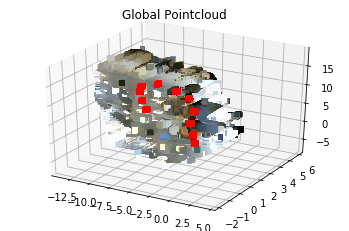

This sliding window took 0.00 seconds
I am now at position [-0.21982997019691114, 0.04950409314004508, 2.311958897733591]
I have found 1 out of 11 spheres!



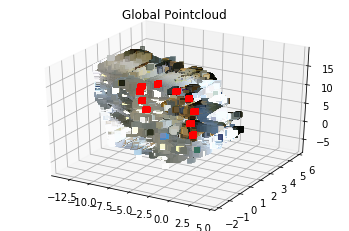

This sliding window took 0.00 seconds
I am now at position [-0.3261756585353453, -0.03395286850258132, 4.6735081412857475]
I have found 2 out of 11 spheres!



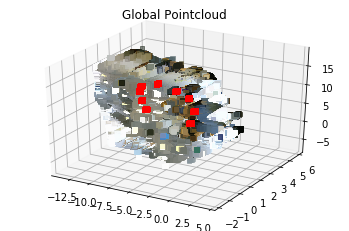

This sliding window took 0.00 seconds
I am now at position [-0.9373297537132663, 0.19822975371326632, 7.008997371364827]
I have found 3 out of 11 spheres!



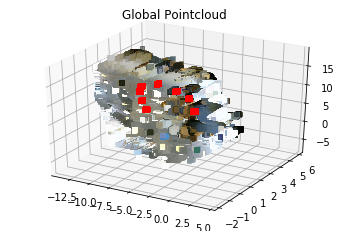

This sliding window took 0.00 seconds
I am now at position [-1.0849520848643157, 0.6048011754614747, 9.390332591106237]
I have found 4 out of 11 spheres!



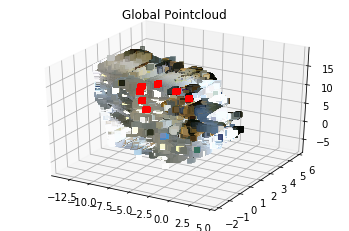

This sliding window took 0.00 seconds
I am now at position [-1.9077063743383007, 0.7579125076961123, 12.17639746548647]
I have found 5 out of 11 spheres!



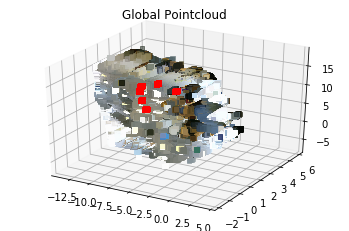

This sliding window took 0.00 seconds
I am now at position [-1.5052992105484009, 1.4520227909088135, 16.378889083862305]
I can not find any red balls!
I am scanning the room....


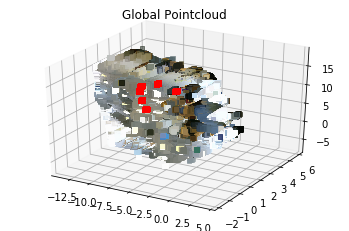

This sliding window took 0.00 seconds
I am now at position [-4.9441986083984375, 0.10896196216344833, 14.165245056152344]
I can not find any red balls!
I am scanning the room....


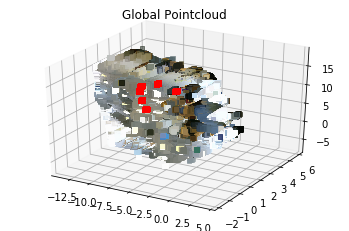

This sliding window took 0.00 seconds
I am now at position [-3.7871880503052746, 1.0716747120324148, 12.89836366083711]
I have found 6 out of 11 spheres!



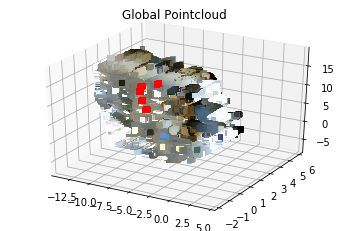

This sliding window took 0.00 seconds
I am now at position [-6.561508264806824, 1.4528867812267594, 13.202228852751967]
I have found 7 out of 11 spheres!



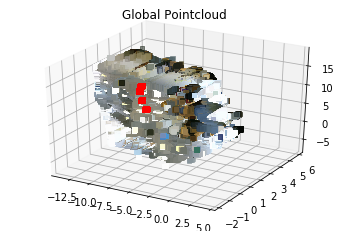

This sliding window took 0.00 seconds
I am now at position [-12.314239501953125, 1.6454755067825317, 13.145886421203613]
I can not find any red balls!
I am scanning the room....


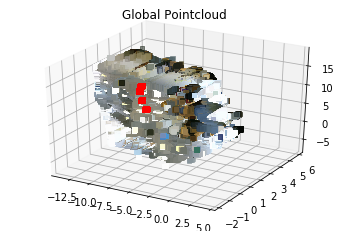

This sliding window took 0.00 seconds
I am now at position [-8.892746433833423, 1.656203511502178, 11.522550963159155]
I have found 8 out of 11 spheres!



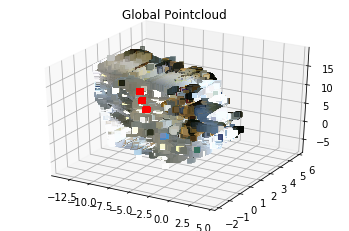

This sliding window took 0.00 seconds
I am now at position [-12.427005767822266, 1.222839117050171, 9.212260246276855]
I can not find any red balls!
I am scanning the room....


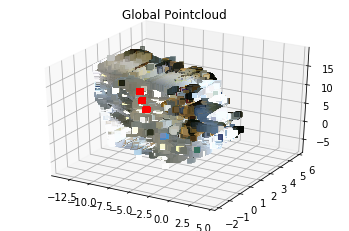

This sliding window took 0.00 seconds
I am now at position [-9.336280373273667, 1.813053835701473, 9.75699077715277]
I have found 9 out of 11 spheres!



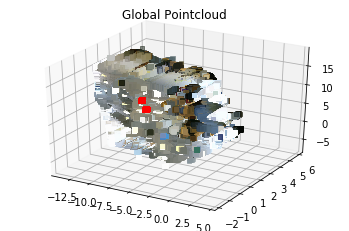

This sliding window took 0.00 seconds
I am now at position [-9.249133263399017, 1.8644722202123687, 7.262820351236514]
I have found 10 out of 11 spheres!



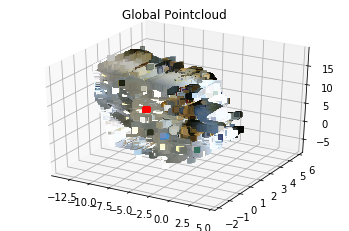

This sliding window took 0.00 seconds
I am now at position [-9.024146685306185, 2.0724156536627993, 4.556540106161687]
I have found 11 out of 11 spheres!

This took 753.31 seconds


In [58]:
# Sliding window 5 steps
global_cloud, spheres_collected = PacMan.startup_scene()

position = np.zeros([3])
angle = np.zeros([3])
previous_position = np.zeros([3])
failed = False
lost = 0

timestamp1 = time.time()

# Get current image from viewpoint
image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, position)

while not np.all(spheres_collected): # While there are spheres to find
    PacMan.show_point_cloud(global_cloud)
    # Extract patches from the scene
    
    # Extracting Window Patches, X and Y center points
    patches, x_center, y_center = sliding_window(5)

    # Extract features from the patches
    
    # Predict the probability of a pixel being a sphere, based on the patch
    # Predicting probabilities on window patches
    patch_probabilities = model.predict_proba(patches)

    # Use probabilities to find sphere coordinates in 3D
    # Get highest probability window location
    image_position, highest_percent = highest_prob(patch_probabilities)

    position[0] = map1[x_center[image_position],y_center[image_position]]
    position[1] = map2[x_center[image_position],y_center[image_position]]
    position[2] = map3[x_center[image_position],y_center[image_position]]
        
    print('I am now at position [{0}, {1}, {2}]'.format(*position))
    
    try:
        global_cloud, spheres_collected = PacMan.update_scene(position, spheres_collected);
        print('I have found {0} out of {1} spheres!\n'.format(np.sum(spheres_collected), len(spheres_collected)));
        for i in range(3):
            previous_position[i] = position[i]
        failed = False
        image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, position)
    except:
        print("I can not find any red balls!")
        print("I am scanning the room....")
        if failed != True:
            for i in range(3):
                position[i] = previous_position[i]
        failed = True
        global_cloud, spheres_collected = PacMan.update_scene(previous_position, spheres_collected);
        
    if failed == True:
        angle[1] -= 0.75
        image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, previous_position)

timestamp2 = time.time()
print ("This took %.2f seconds" % (timestamp2 - timestamp1))

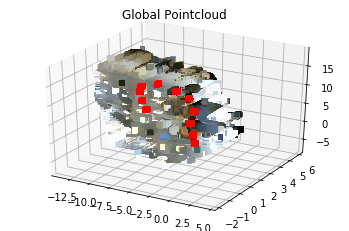

This sliding window took 0.00 seconds
I am now at position [-0.2603576553033593, 0.04575819465891323, 2.330109222847228]
I have found 1 out of 11 spheres!



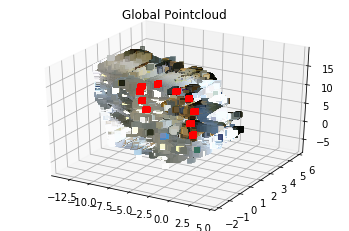

This sliding window took 0.00 seconds
I am now at position [-0.30979611564706433, -0.05999633903243528, 4.675964804229028]
I have found 2 out of 11 spheres!



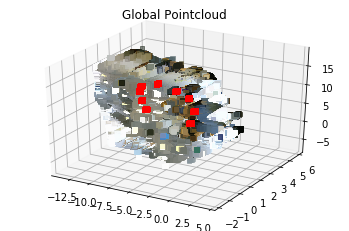

This sliding window took 0.00 seconds
I am now at position [-0.9594036314131209, 0.20076470856570022, 7.00876503318728]
I have found 3 out of 11 spheres!



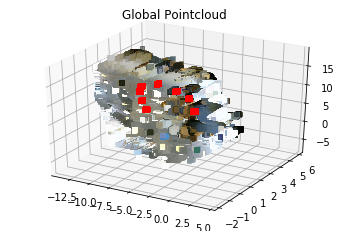

This sliding window took 0.00 seconds
I am now at position [-1.067506289440756, 0.5703172267978487, 9.404354325596616]
I have found 4 out of 11 spheres!



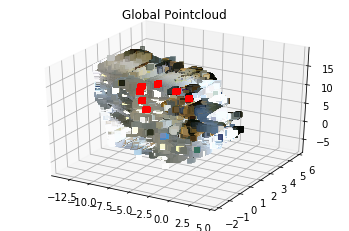

This sliding window took 0.00 seconds
I am now at position [-1.9313620156359446, 0.78851665238899, 12.175456851044984]
I have found 5 out of 11 spheres!



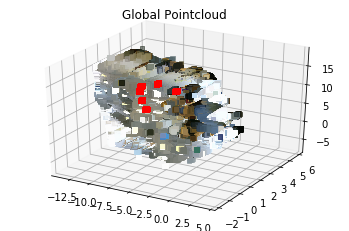

This sliding window took 0.00 seconds
I am now at position [-1.5855178833007812, 1.4204193353652954, 16.325119018554688]
I can not find any red balls!
I am scanning the room....


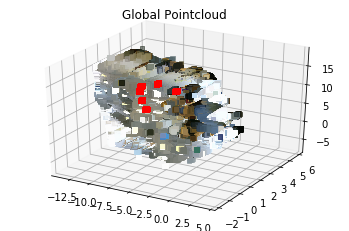

This sliding window took 0.00 seconds
I am now at position [-4.996821880340576, 0.1322949230670929, 14.172106742858887]
I can not find any red balls!
I am scanning the room....


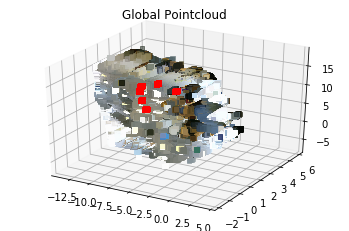

This sliding window took 0.00 seconds
I am now at position [-10.051514625549316, 2.0395026206970215, 15.119159698486328]
I can not find any red balls!
I am scanning the room....


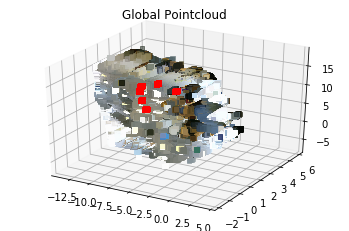

This sliding window took 0.00 seconds
I am now at position [-9.0039644241333, 1.7582118511199951, 7.373073101043701]
I can not find any red balls!
I am scanning the room....


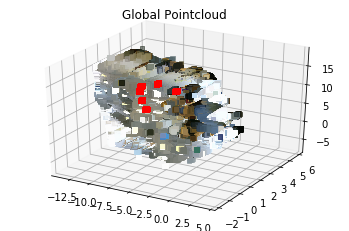

This sliding window took 0.00 seconds
I am now at position [-1.8096544742584229, 1.2999426126480103, 8.72331428527832]
I can not find any red balls!
I am scanning the room....


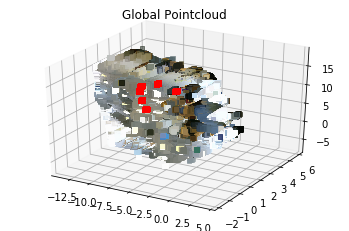

This sliding window took 0.00 seconds
I am now at position [0.1304793655872345, 1.0238741636276245, 7.672539234161377]
I can not find any red balls!
I am scanning the room....


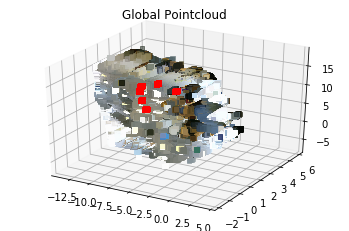

This sliding window took 0.00 seconds
I am now at position [0.0, 0.0, 0.0]
I can not find any red balls!
I am scanning the room....


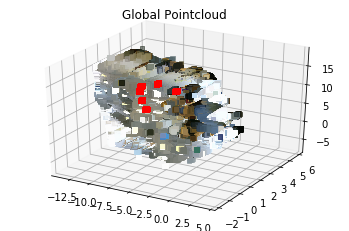

This sliding window took 0.00 seconds
I am now at position [0.8374701738357544, 0.1321260929107666, 14.600817680358887]
I can not find any red balls!
I am scanning the room....


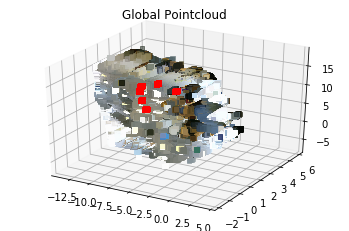

This sliding window took 0.00 seconds
I am now at position [-1.5136476755142212, 1.416122317314148, 16.36783790588379]
I can not find any red balls!
I am scanning the room....


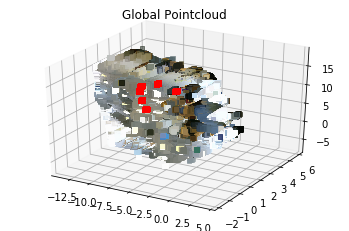

This sliding window took 0.00 seconds
I am now at position [-2.4621236324310303, 1.1081840991973877, 14.224205017089844]
I can not find any red balls!
I am scanning the room....


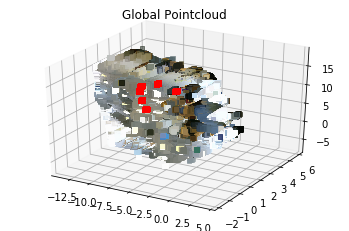

This sliding window took 0.00 seconds
I am now at position [-3.7773268055491687, 1.0790881320282477, 12.902385387284646]
I have found 6 out of 11 spheres!



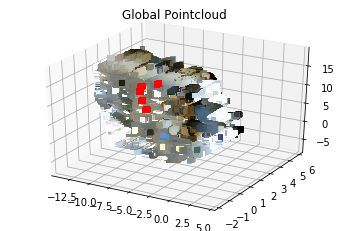

This sliding window took 0.00 seconds
I am now at position [-6.556997418425649, 1.472938114634385, 13.21579676663562]
I have found 7 out of 11 spheres!



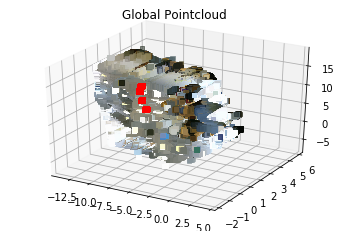

This sliding window took 0.00 seconds
I am now at position [-10.248151779174805, 2.119194984436035, 15.380865097045898]
I can not find any red balls!
I am scanning the room....


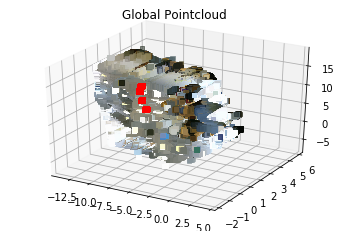

This sliding window took 0.00 seconds
I am now at position [-8.888983097494243, 1.6252351907289888, 11.491738137932948]
I have found 8 out of 11 spheres!



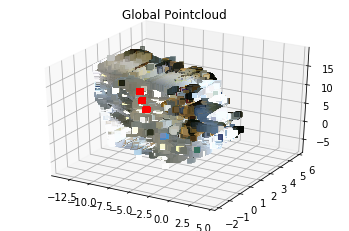

This sliding window took 0.00 seconds
I am now at position [0.0, 0.0, 0.0]
I can not find any red balls!
I am scanning the room....


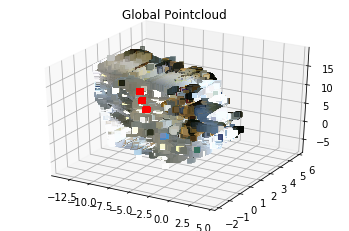

This sliding window took 0.00 seconds
I am now at position [-9.329281498782324, 1.8237310200402166, 9.751589551733336]
I have found 9 out of 11 spheres!



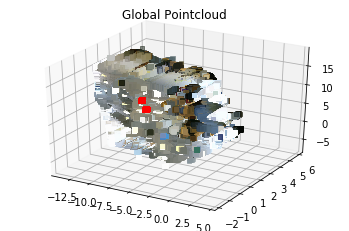

This sliding window took 0.00 seconds
I am now at position [0.0, 0.0, 0.0]
I can not find any red balls!
I am scanning the room....


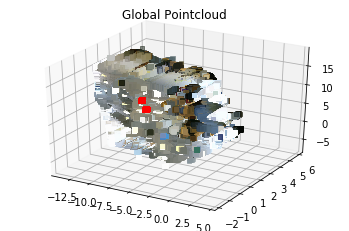

This sliding window took 0.00 seconds
I am now at position [-9.217618241188147, 1.8593440078629533, 7.249014213944668]
I have found 10 out of 11 spheres!



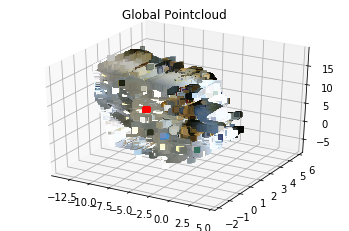

This sliding window took 0.00 seconds
I am now at position [-9.01371487766234, 2.0743662388315127, 4.555556591794975]
I have found 11 out of 11 spheres!

This took 955.60 seconds


In [59]:
# Sliding window 10 steps
global_cloud, spheres_collected = PacMan.startup_scene()

position = np.zeros([3])
angle = np.zeros([3])
previous_position = np.zeros([3])
failed = False

timestamp1 = time.time()

# Get current image from viewpoint
image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, position)

while not np.all(spheres_collected): # While there are spheres to find
    PacMan.show_point_cloud(global_cloud)
    # Extract patches from the scene
    
    # Extracting Window Patches, X and Y center points
    patches, x_center, y_center = sliding_window(10)

    # Extract features from the patches
    
    # Predict the probability of a pixel being a sphere, based on the patch
    # Predicting probabilities on window patches
    patch_probabilities = model.predict_proba(patches)

    # Use probabilities to find sphere coordinates in 3D
    # Get highest probability window location
    image_position, highest_percent = highest_prob(patch_probabilities)

    position[0] = map1[x_center[image_position],y_center[image_position]]
    position[1] = map2[x_center[image_position],y_center[image_position]]
    position[2] = map3[x_center[image_position],y_center[image_position]]
        
    print('I am now at position [{0}, {1}, {2}]'.format(*position))
    
    try:
        global_cloud, spheres_collected = PacMan.update_scene(position, spheres_collected);
        print('I have found {0} out of {1} spheres!\n'.format(np.sum(spheres_collected), len(spheres_collected)));
        for i in range(3):
            previous_position[i] = position[i]
        failed = False
        image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, position)
    except:
        print("I can not find any red balls!")
        print("I am scanning the room....")
        if failed != True:
            for i in range(3):
                position[i] = previous_position[i]
        failed = True
        global_cloud, spheres_collected = PacMan.update_scene(previous_position, spheres_collected);
        
    if failed == True:
        angle[1] -= 0.75
        image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, previous_position)

timestamp2 = time.time()
print ("This took %.2f seconds" % (timestamp2 - timestamp1))

### End of experiment